In [24]:
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
plots.style.use('fivethirtyeight')

## Lecture 34

In [25]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def get_fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def get_residuals(t, x, y):
    predictions = get_fitted_values(t, x, y)
    return t.column(y) - predictions

## Regression Model 

Let's examine the relationship between:

- True regression line that captures the linear relationship between two variables (green line)
- A random sample of n points that come from the underlying linear relationship plus random noise off the regression line
- A line fit to the sample of points that approximates the true regression line (i.e., the "line best fit" shown in blue)

To do this we will use the function `draw_and_compare` defined below that takes three arguments:

1. The true slope of a linear relationship between our variables
2. The true y-intercept of a linear relationship between our variables
3. A sample size (n) of random points that will be used to calculate the "line of best fit"



In [26]:
def draw_and_compare(true_slope, true_int, sample_size):
    
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

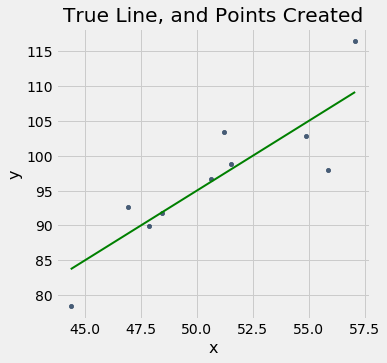

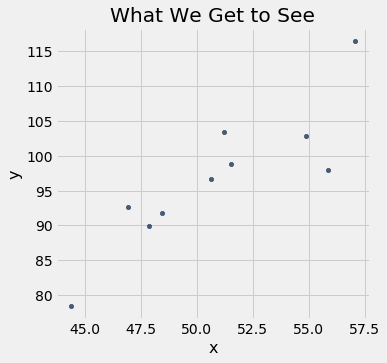

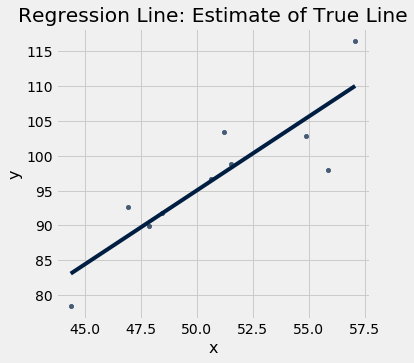

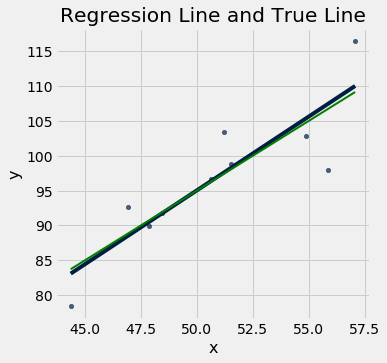

In [27]:
# have a true slope of 2, an true intercept of -5 and draw 10 random points
draw_and_compare(2, -5, 10)

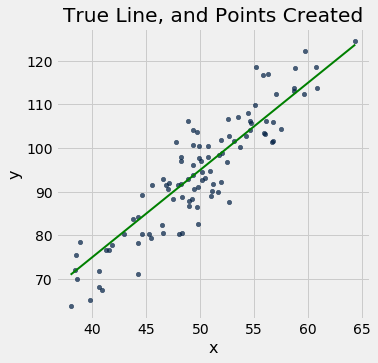

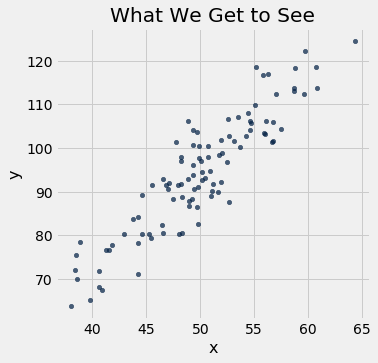

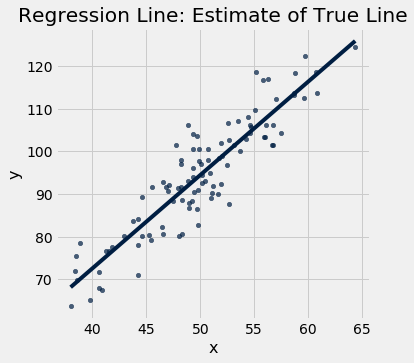

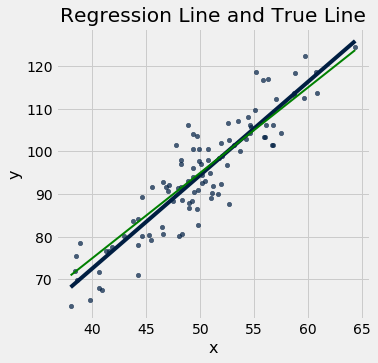

In [28]:
# have a true slope of 2, an true intercept of -5 and draw 100 random points
draw_and_compare(2, -5, 100)

## Bootstrap slopes, intercepts and regression lines

In [29]:
# load data on fruits
fruit = Table.read_table('fruit_baskets.csv')
fruit.show(3)

Bananas,Clementines,Weight
9,19,7.91585
4,25,6.69871
5,26,7.3679


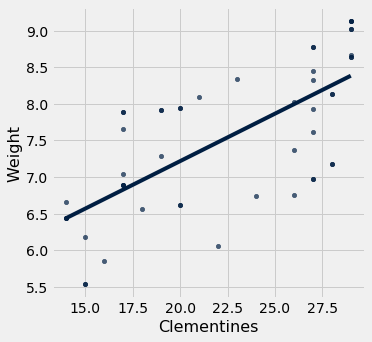

In [30]:
# take a random sample (with replacement) from our original fruit sample and fit a regression line
fruit_sample = fruit.sample()
fruit_sample.scatter('Clementines', 'Weight', fit_line = True)

In [31]:
# create a bootstrap distribution for the slope and intercept
bootstrap_slopes = make_array()
bootstrap_intercepts = make_array()

for i in np.arange(1000):
    
    fruit_sample = fruit.sample()
    bootstrap_slopes = np.append(bootstrap_slopes, slope(fruit_sample, 'Clementines', 'Weight'))
    bootstrap_intercepts = np.append(bootstrap_intercepts, intercept(fruit_sample, 'Clementines', 'Weight'))


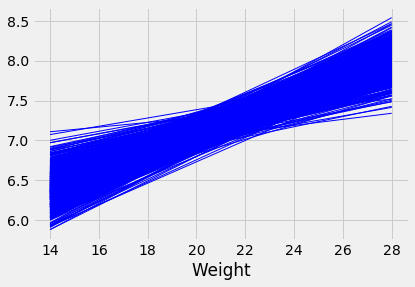

In [32]:
# visualize all the bootstrap lines
xlims = make_array(14, 28)

for i in np.arange(len(bootstrap_slopes)):
    plots.plot(xlims, bootstrap_slopes[i] * xlims + bootstrap_intercepts[i], lw=1, color = "blue", alpha = 1);
    plots.xlabel("Clementines")
    plots.xlabel("Weight")

In [33]:
# create a 95% confidence interval for the regression slope
bootstrap_CI = make_array(percentile(2.5, bootstrap_slopes), percentile(97.5, bootstrap_slopes))
bootstrap_CI

array([0.0674331 , 0.15311039])

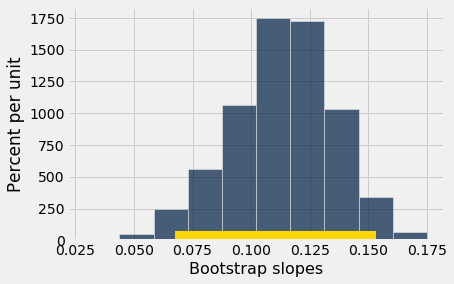

In [34]:
# visualize the bootstrap distribution
Table().with_column("Bootstrap slopes", bootstrap_slopes).hist("Bootstrap slopes")
plots.plot(bootstrap_CI, [0, 0], color='gold', lw=18);

# Question:
#  Is a slope of 0 plausible?  
#  i.e, no linear association between the number of Clementines and Weight?


### Question: could you run a hypothesis test assessing whether the regression slope is 0? 

In [35]:
# create a null distribution 

null_fruit_slopes = make_array()

for i in np.arange(1000):
    fruit_shuff = fruit.with_column('Weight', fruit.sample(with_replacement = False).column("Weight"))
    null_fruit_slopes =  np.append(null_fruit_slopes, slope(fruit_shuff, 'Clementines', 'Weight'))



0.11468767835062636

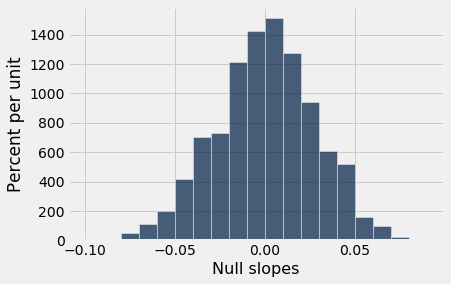

In [36]:
Table().with_column("Null slopes", null_fruit_slopes).hist("Null slopes", bins = np.arange(-.1, .1, .01))
real_slope = slope(fruit, 'Clementines', 'Weight')
real_slope

## Classification

In [37]:
# Can you tell if a bank note is counterfeit or legitimate?
# Variables based on photgraphs of many banknotes (a few numbers for each image calculated)

banknotes = Table.read_table('banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


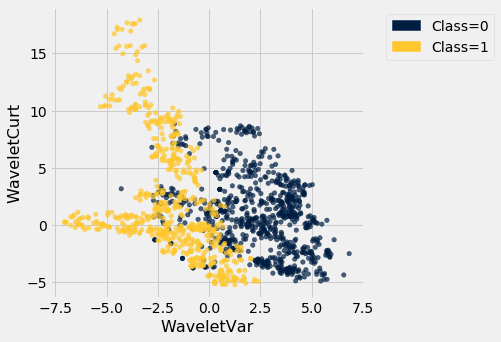

In [38]:
# Visualize 'WaveletVar' and 'WaveletCurt'
banknotes.scatter('WaveletVar', 'WaveletCurt', colors='Class')

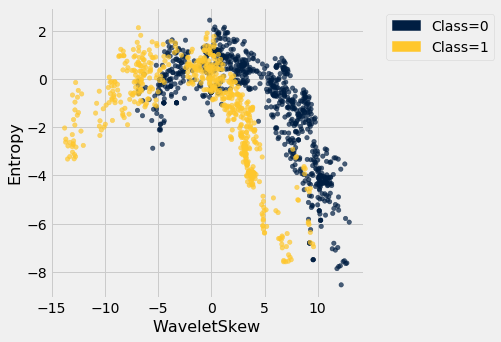

In [39]:
# Visualize 'WaveletSkew', 'Entropy'
banknotes.scatter('WaveletSkew', 'Entropy', colors='Class')

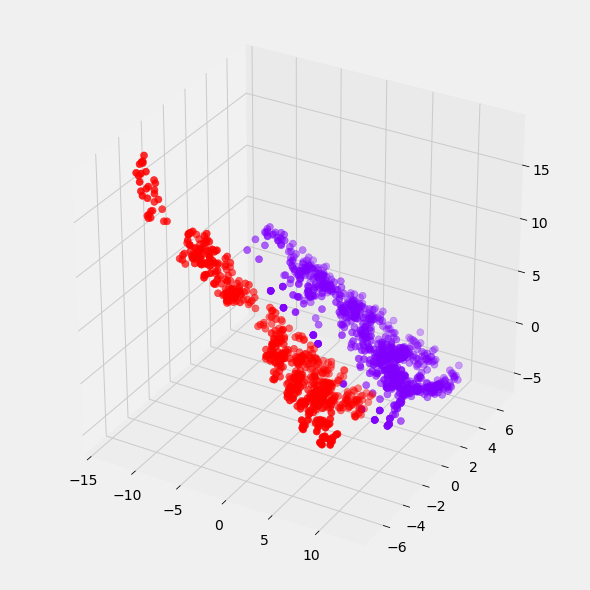

In [40]:
# Two attributes have some overlap of classes...what happens with three attributes?
fig = plots.figure(figsize=(8,8))
ax = Axes3D(fig)

ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),
           cmap='rainbow', #'viridis',
          s=50);